# LSTM
Try to make masking work.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-11 16:50:38.671345
Python 3.10.0
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
EPOCHS=2
FOLDS=5  
BREAK = True   # break after first fold
MINLEN=200
MAXLEN=1000   # this is problematic as some genes will be excluded entirely or partially

2022-12-11 16:50:42.277925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

/Users/jasonmiller/WVU/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [6]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-12-11 16:50:51.886872
Num RCI: 3327
[('ENSG00000099869', 1.0), ('ENSG00000116652', 1.65208), ('ENSG00000117242', -0.793877)]


In [7]:
def seq_to_kmers(rna,K):
    VALS = {'A':0, 'C':1, 'G':2, 'T':3}
    length = len(rna)
    vec=[]
    for i in range(length-K+1):
        value = 0
        for j in range(K):
            value *= 4   
            nextnuc = rna[i+j]
            if nextnuc=='N':
                value = -1   # indicate an N
                break
            nucval = VALS[nextnuc]
            value += nucval
        value += 1   # NNN => 0, AAA => 1
        vec.append(value)
    return vec
print(seq_to_kmers('AAAA',3))
print(seq_to_kmers('CATT',3))
print(seq_to_kmers('TTGA',3))
print(seq_to_kmers('TTTN',3))

[1, 1]
[20, 16]
[63, 57]
[64, 0]


In [8]:
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmers(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-12-11 16:50:51.956072
Load sequence
2022-12-11 16:50:58.578795
Num IDs: 7591
Num labels: 7591
Num counts: 7591


In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [42]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    EMBED_DIMEN = 16 # arbitrary hyperparameter
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # To do: try with and without masking layer
    # To do: try the embedding layer with mask, instead of masking layer
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, K))
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, 1))
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn1_layer = LSTM(32, return_sequences=False) # True)
    # rnn1_layer = Bidirectional( LSTM(32, return_sequences=True) )
    # rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    # dense1_layer = Dense(16,activation='sigmoid',dtype=dt)
    # dropout1_layer = Dropout(0.50)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    #rnn.add(dense1_layer)
    #rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [43]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-11 17:03:24.843724
COMPILE
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 997, 16)           4112      
                                                                 
 lstm_15 (LSTM)              (None, 32)                6272      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,417
Trainable params: 10,417
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        print('Training example')
        print(X_train[0])
        
        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
        
        if BREAK:
            break
        
    print()
    return cv_scores
print(datetime.now())

2022-12-11 17:03:26.221778


2022-12-11 17:03:26.257976
2022-12-11 17:03:26.259458
splitting
Fold 1
Training example
[186 229 146  69  18  71  27 106 168 158 118 214  85  84  79  58 231 156
 112 191 252 238 184 224 126 246 215  89  99 138  39 156 110 181 211  75
  42 166 151  90 102 150  86  88  93 114 198  22  87  92 111 186 232 160
 128 254 248 223 122 232 158 120 223 122 229 147  73  34 134  22  88  94
 120 224 126 246 216  93 115 201  34 134  24  94 118 215  92 110 182 216
  96 128 255 252 238 182 214  85  84  78  55 218 104 159 122 230 152  96
 126 246 214  86  88  94 117 209  67  10  40 158 117 211  75  43 170 166
 149  81  67  10  40 159 124 238 182 215  90 102 149  81  66   6  24  94
 119 219 106 168 158 118 216  94 118 215  91 107 170 165 147  74  38 150
  88  94 119 218 102 150  87  91 107 171 172 175 186 231 154 102 150  86
  87  91 107 171 170 165 147  75  41 162 134  22  86  86  85  83  74  38
 150  85  82  71  26 102 150  85  83  75  43 170 166 150  87  90 102 150
  86  88  95 122 230 150  88  94 118

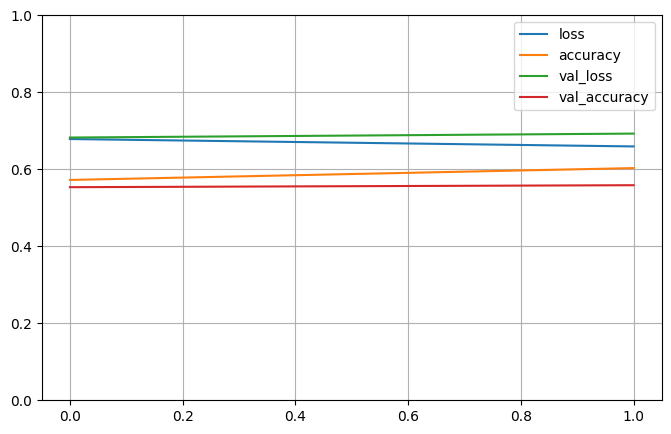

Compute valiation accuracy
2022-12-11 17:06:36.176208
accuracy: 55.86%
2022-12-11 17:06:41.689971

Cross validation acc mean 55.86% (+/- 0.00%)
2022-12-11 17:06:41.690461


In [45]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())